In [1]:
import os
import torch
import shutil
import torchvision
import pandas as pd
import lightning as L
import matplotlib.pyplot as plt

In [2]:
class COVIDXDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        path,
        split,
        transform=None,
        shuffle=False,
    ):
        self.path = path
        self.split = split
        self.transform = transform

        self.data = pd.read_csv(f"{self.path}/{self.split}.txt", sep=" ", header=None)
        self.data.columns = ["pid", "filename", "class", "source"]
        if shuffle:
            self.data = self.data.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        filename = f"{self.path}/{self.split}/{row['filename']}"
        image = torchvision.io.read_image(filename, mode=torchvision.io.image.ImageReadMode.GRAY)
        image = image.float() / 255.0
        image = image.expand(3, -1, -1)
        label = (row["class"] == "positive") * 1
        if self.transform:
            image = self.transform(image)
        return image, label

class COVIDXDataModule(L.LightningDataModule):
    def __init__(
        self,
        path="data/raw/COVIDX-CXR4",
        transform=None,
        batch_size=32,
        train_shuffle=False,
        seed=None,
    ):
        super().__init__()
        self.path = path
        self.transform = transform
        self.batch_size = batch_size
        self.train_shuffle = train_shuffle
        self.seed = seed
        if seed:
            torch.manual_seed(seed)

    def setup(self):
        self.train_dataset = COVIDXDataset(
            path=self.path, split="train", transform=self.transform, shuffle=self.train_shuffle
        )
        self.val_dataset = COVIDXDataset(path=self.path, split="val", transform=self.transform)
        self.test_dataset = COVIDXDataset(path=self.path, split="test", transform=self.transform)
        return self

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size)

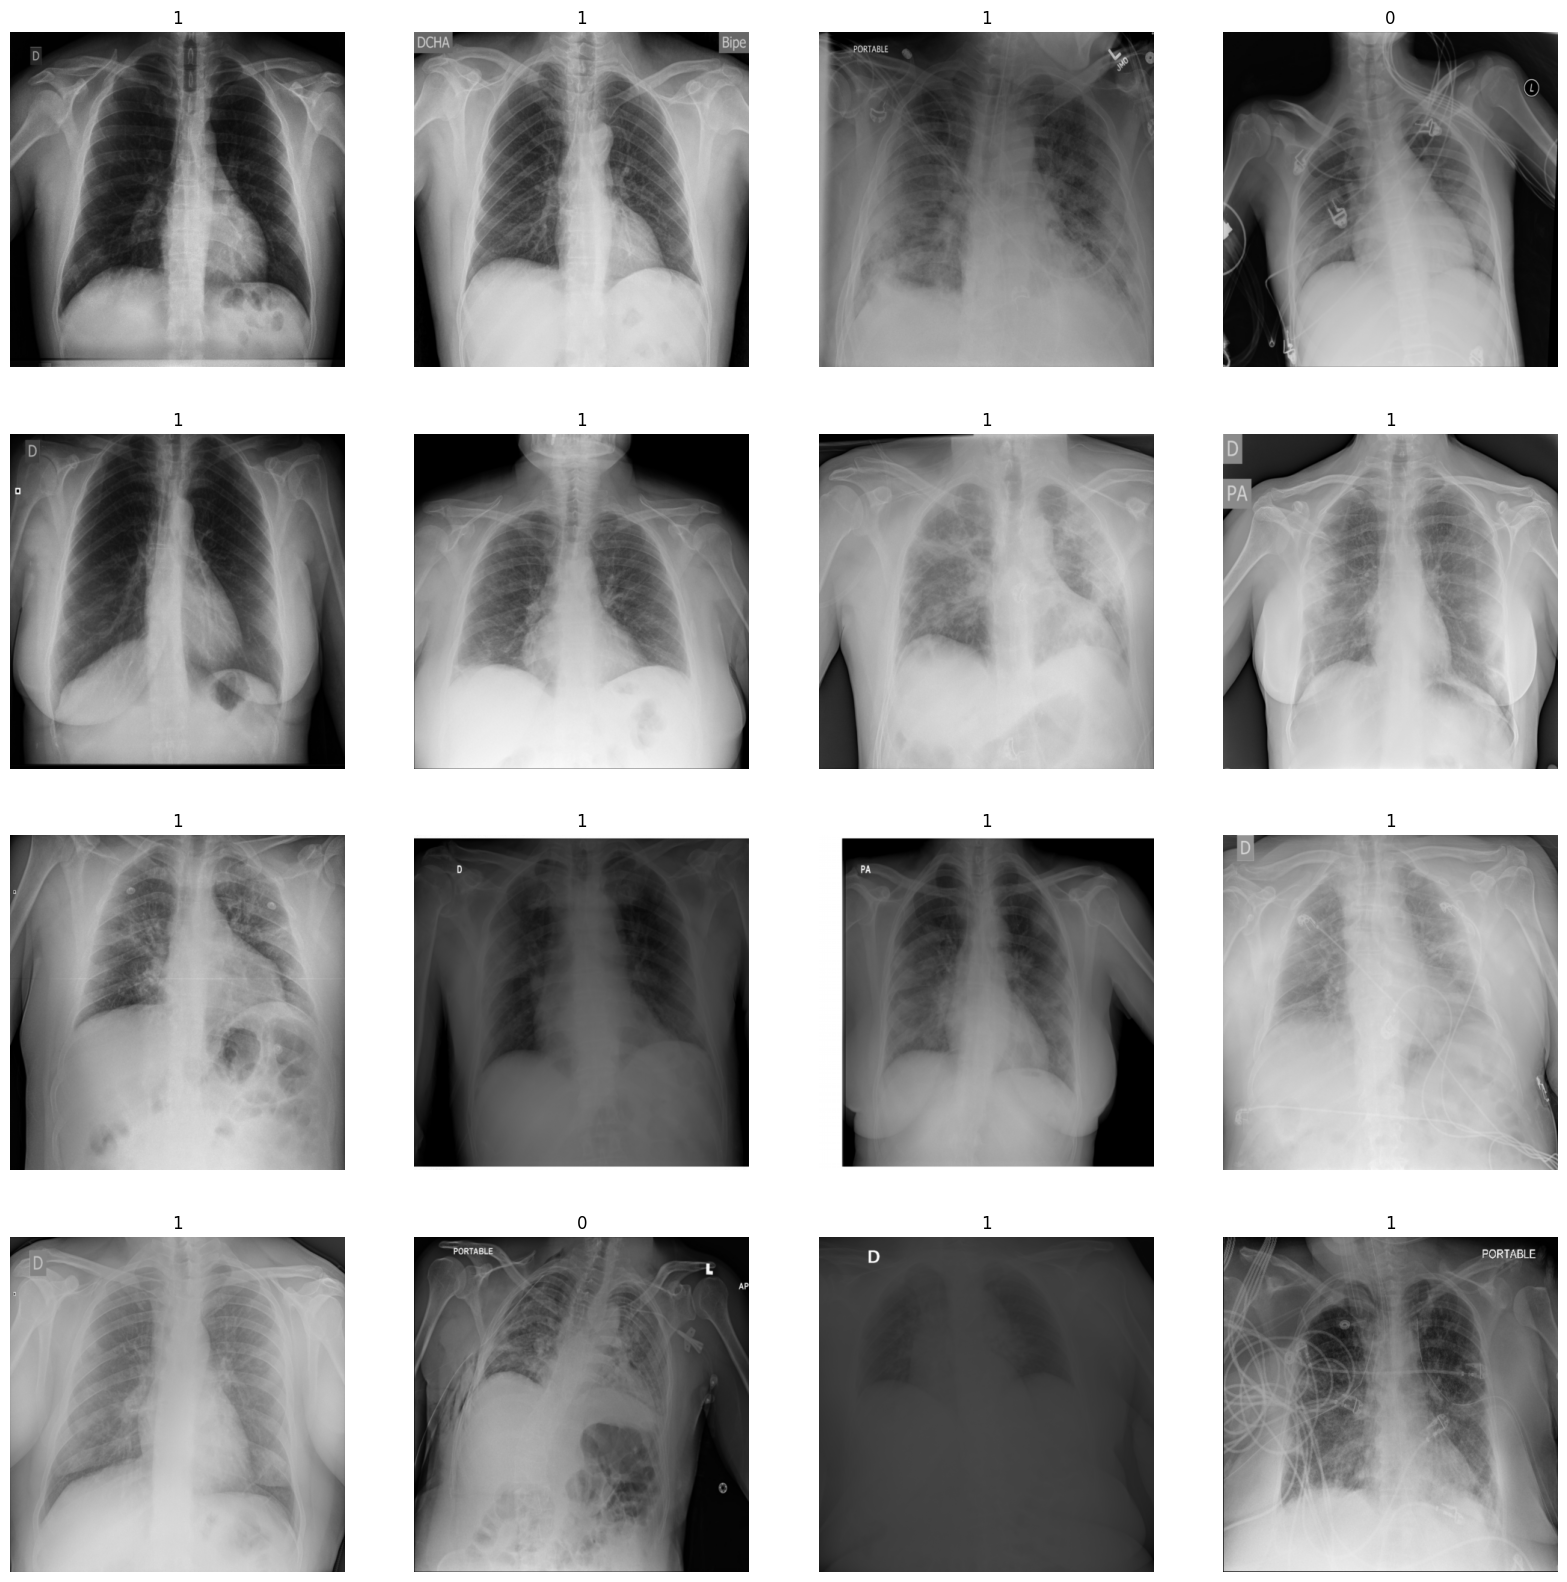

In [3]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((448, 448), antialias=True),
        # torchvision.transforms.RandomRotation(10),
        # torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
    ]
)

data = COVIDXDataModule(
    path="../data/raw/COVIDX-CXR4",
    transform=transform,
    batch_size=16,
).setup()

for batch in data.train_dataloader():
    image, label = batch
    plt.figure(figsize=(20, 20))
    for i in range(image.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(image[i].permute(1, 2, 0).clip(0, 1), cmap="gray")
        plt.axis("off")
        plt.title(label[i].item())
    break

---


In [4]:
class MRIDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        path,
        split,
        transform=None,
        shuffle=False,
    ):
        self.path = path
        self.split = split
        self.transform = transform
        self.shuffle = shuffle

        self.data = pd.read_csv(f"{self.path}/{self.split}.txt", sep=" ", header=None)
        self.data.columns = ["filename", "class", "label"]
        if shuffle:
            self.data = self.data.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        filename = f"{self.path}/{self.split}/{row['filename']}"
        image = torchvision.io.read_image(filename, mode=torchvision.io.image.ImageReadMode.GRAY)
        image = image.float() / 255.0
        image = image.expand(3, -1, -1)
        label = row["label"]
        if self.transform:
            image = self.transform(image)
        return image, label

class MRIDataModule(L.LightningDataModule):
    def __init__(
        self,
        path="data/raw/Brain-Tumor-MRI",
        path_processed="data/processed/Brain-Tumor-MRI",
        transform=None,
        batch_size=32,
        train_val_ratio=0.8,
        train_shuffle=False,
        seed=None,
    ):
        super().__init__()
        self.path = path
        self.path_processed = path_processed
        self.transform = transform
        self.batch_size = batch_size
        self.train_val_ratio = train_val_ratio
        self.train_shuffle = train_shuffle
        self.seed = seed
        if seed:
            torch.manual_seed(seed)

    def setup(self):
        if not os.path.exists(self.path_processed):
            self._copy_files()
            self._generate_labels_files()

        self.train_dataset = MRIDataset(
            self.path_processed, "train", transform=self.transform, shuffle=self.train_shuffle
        )
        self.val_dataset = MRIDataset(self.path_processed, "val", transform=self.transform)
        self.test_dataset = MRIDataset(self.path_processed, "test", transform=self.transform)
        return self

    def _copy_files(self):
        os.makedirs(f"{self.path_processed}/train", exist_ok=True)
        os.makedirs(f"{self.path_processed}/val", exist_ok=True)
        os.makedirs(f"{self.path_processed}/test", exist_ok=True)

        self._process_files(
            source_path=f"{self.path}/Training",
            dest_path=f"{self.path_processed}/train",
            dest_path_2=f"{self.path_processed}/val",
            is_training=True,
        )

        self._process_files(
            source_path=f"{self.path}/Testing",
            dest_path=f"{self.path_processed}/test",
            is_training=False,
        )

    def _process_files(
        self,
        source_path,
        dest_path,
        dest_path_2=None,
        is_training=True,
    ):
        for tumor_label in os.listdir(source_path):
            files = os.listdir(f"{source_path}/{tumor_label}")

            if is_training:
                num_val_files = int(len(files) * (1 - self.train_val_ratio))
                indices = torch.randperm(len(files))[:num_val_files]
                val_files = set(files[i] for i in indices)

            for file_path in files:
                new_file_name = f"{tumor_label}_{file_path}"
                file_dest_path = (
                    f"{dest_path_2}/{new_file_name}"
                    if is_training and file_path in val_files
                    else f"{dest_path}/{new_file_name}"
                )
                shutil.copy(f"{source_path}/{tumor_label}/{file_path}", file_dest_path)

    def _generate_labels_files(self):
        for dataset_type in ["train", "val", "test"]:
            path = f"{self.path_processed}/{dataset_type}"
            files = [f for f in os.listdir(path) if f.endswith(".jpg")]

            # Create a DataFrame with the required data
            df = pd.DataFrame(
                {
                    "filename": files,
                    "class": ["_".join(f.split("_")[:2]) for f in files],
                    "label": [0 if "no_" in f else 1 for f in files],
                }
            )

            # Write the DataFrame to a text file
            df.to_csv(f"{path}.txt", sep=" ", index=False, header=False)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size)

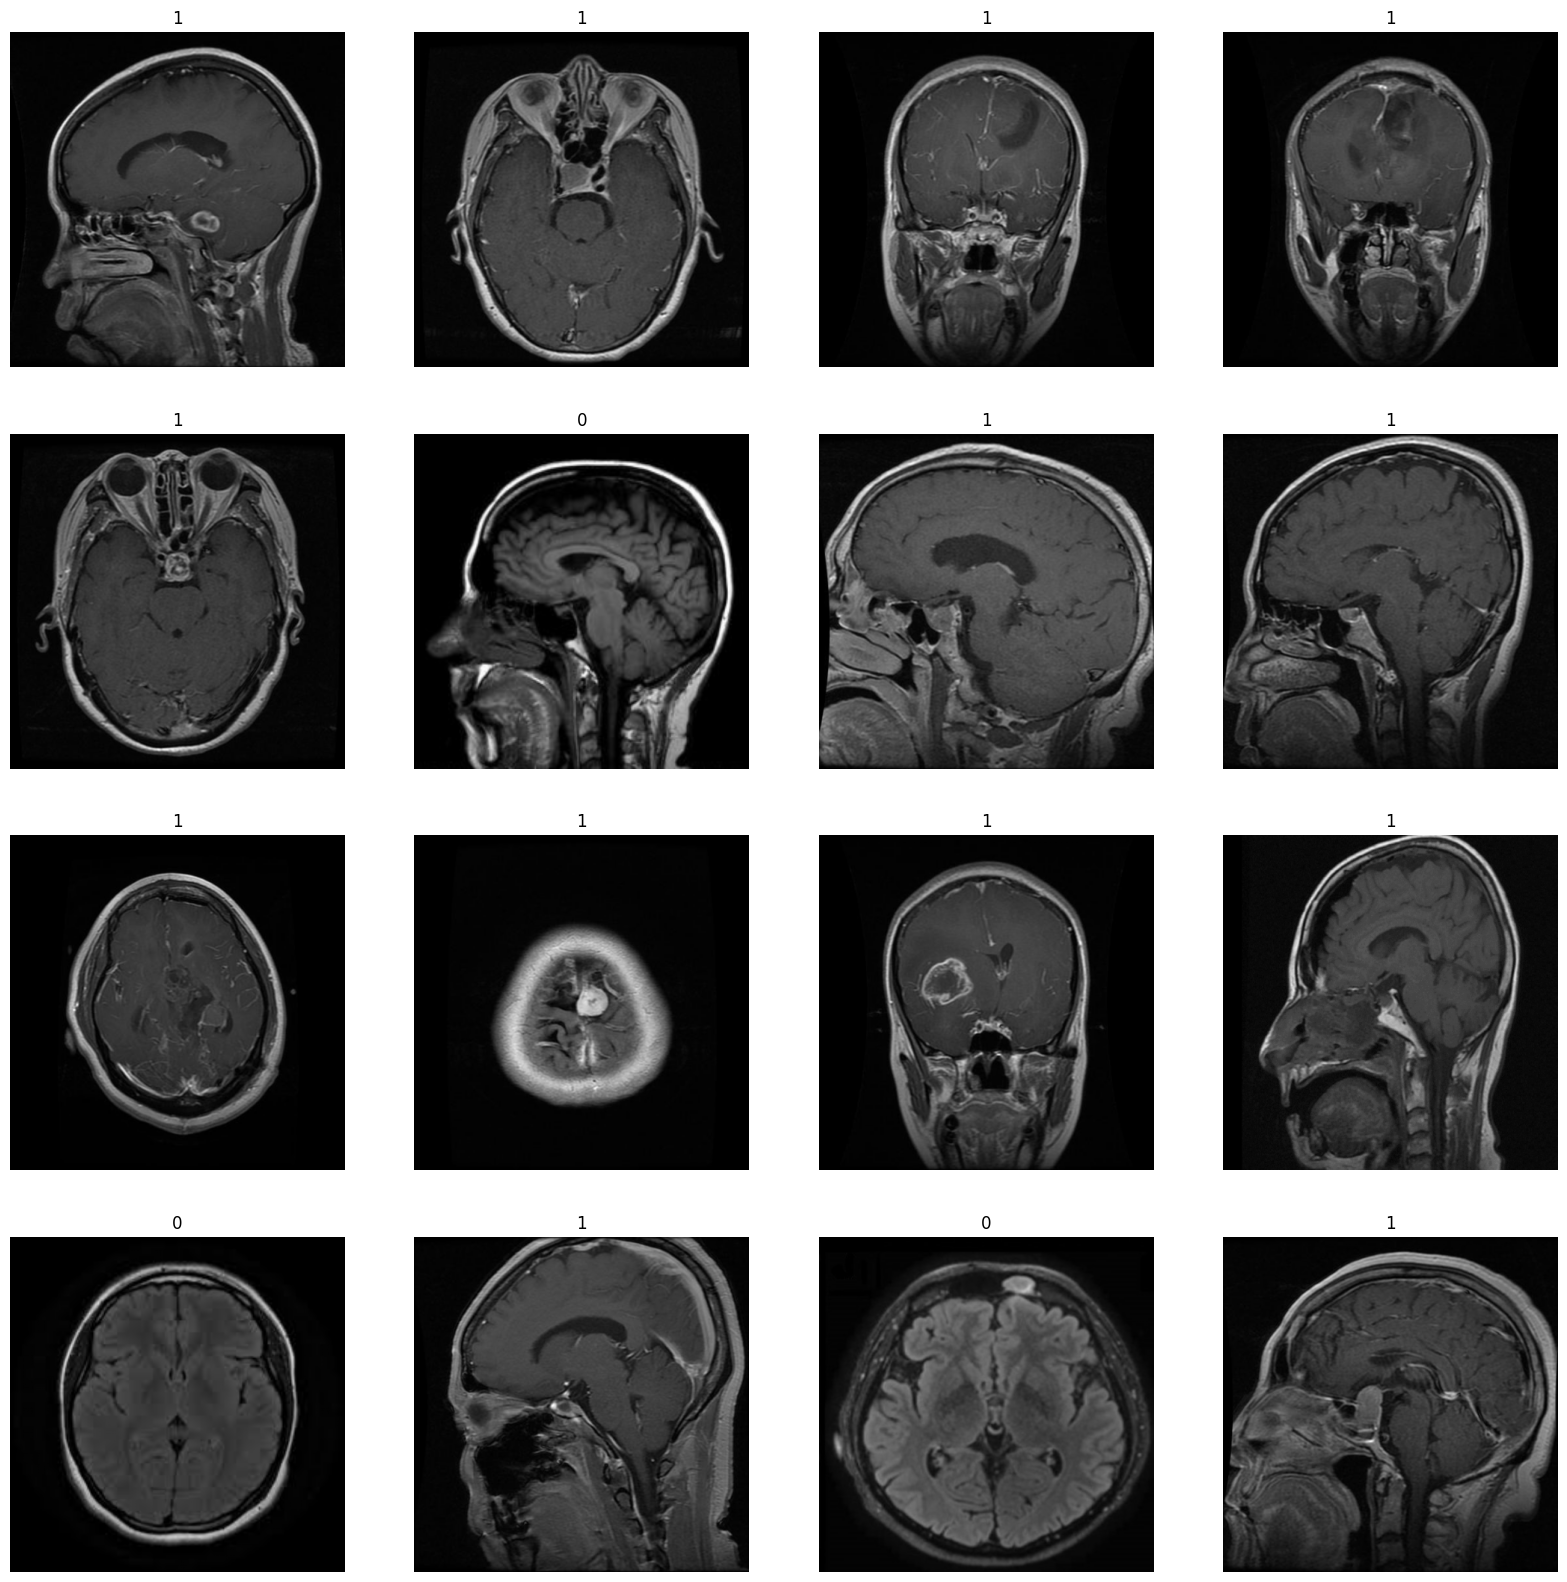

In [5]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((448, 448), antialias=True),
        # torchvision.transforms.RandomRotation(10),
        # torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
    ]
)

data = MRIDataModule(
    path="../data/raw/Brain-Tumor-MRI",
    path_processed="../data/processed/Brain-Tumor-MRI",
    transform=transform,
    batch_size=16,
    train_shuffle=True,
).setup()

for batch in data.train_dataloader():
    image, label = batch
    plt.figure(figsize=(20, 20))
    for i in range(image.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(image[i].permute(1, 2, 0).clip(0, 1), cmap="gray")
        plt.axis("off")
        plt.title(label[i].item())
    break